In [1]:
from __future__ import print_function

# https://qiita.com/kzkadc/items/e4fc7bc9c003de1eb6d0
# argument Parser
import argparse

import os
import random
import math
import torch
import torch.nn as nn
#import torch.legacy.nn as lnn # do not use?
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision 
#from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [2]:
import ownmodels

In [3]:
# initial setting
opt = {'dataset':'folder',
       'dataroot':'celebA/img_align_celeba/',
       'workers':0,
       'batchSize':128,
       'imageSize':64,
       'nz':512,
       'ngf':64,
       'ndf':64,
       'niter':25,
       'saveInt':5,
       'lr':0.0002,
       'beta1':0.5,
       'cuda':True,
       'ngpu':1,
       'netG': '', # if you continue, input the path
       'netD': '', # if you continue, input the path
       'outf':'./output_model',
       'manualSeed':462528}

# iptの値の一部をグローバル変数に格納
ngpu = int(opt['ngpu']) # GPUの数
nz = int(opt['nz']) # 潜在変数のベクトル長 デフォルトは100
ngf = int(opt['ngf']) # デフォルトは64
ndf = int(opt['ndf']) # デフォルトは64
nc = 3 # チャンネル数は3で固定

In [4]:
# 引数にmanualSeedが渡された場合の処理
# https://qiita.com/chat-flip/items/4c0b71a7c0f5f6ae437f
if opt['manualSeed'] is None:
    opt['manualSeed'] = random.randint(1, 10000) # manualSeedがNoneの場合、1~10000の間の一様乱数から整数を取得してseedにする
print("Random Seed: ", opt['manualSeed']) # 設定されたseedをprint

Random Seed:  462528


In [5]:
attr_list = []

# ファイルをオープンする
test_data = open('./celebA/list_attr_celeba.txt', "r")

# 一行ずつ読み込んでは表示する
i = 0
for line in test_data:
    if i == 1:
        name = line.split()
    if i >= 2:
        out = line.split()
        attr_list.append(out)
    i += 1

# ファイルをクローズする
test_data.close()

In [6]:
# ref : https://tips-memo.com/pytorch-dataset
# define transform
transform=transforms.Compose([
    transforms.Resize(opt['imageSize']),
    transforms.CenterCrop(opt['imageSize']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

imgDataset = ownmodels.MyDataset(attr_list, opt['dataroot'], transform=transform)

In [7]:
len(imgDataset)

202599

In [8]:
# dataloaderの定義
dataloaders = torch.utils.data.DataLoader(imgDataset, batch_size=opt['batchSize'],
                                          shuffle=False, num_workers=opt['workers'])

3 torch.Size([128, 3, 64, 64])


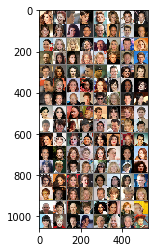

In [9]:
# dataloaderをイテレータオブジェクトにしてnextの要素を格納する
inputs = next(iter(dataloaders)) #https://algorithm.joho.info/programming/python/iter-next-py/

# inputs画像を使ってグリッドを生成する
out = torchvision.utils.make_grid(inputs[0]) # https://blog.shikoan.com/torchvision-image-tile/
print(len(inputs),
      inputs[0].size())

ownmodels.imshow(out)

In [10]:
# 生成ネットワークの定義
netG = ownmodels._netG(opt, opt['imageSize'],ngpu, ngf, nz, nc)
# applyはnetG内でselfで定義されたサブモジュールに対して(fn)の関数を適用する
# この場合はweights_initなので、重みの初期化を全サブモジュールに対して適用している
netG.apply(ownmodels.weights_init)
# すでに何らかの学習が行われておりnetGが空でない場合はすでにあるnetGから読み込みを行う
if opt['netG'] != '':
    netG.load_state_dict(torch.load(opt['netG']))
print(netG)

_netG(
  (encoder): _Encoder(
    (conv1): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (encoder): Sequential(
      (input-conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (input-relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (pyramid_64-128_conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (pyramid_128_batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pyramid_128_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (pyramid_128-256_conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (pyramid_256_batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pyramid_256_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (pyramid_256-512_conv): Conv2d(256, 512, kernel_size=(4, 4), str

In [11]:
# 損失関数にはそれぞれBCELoss(Binary Cross Entropy Loss)とMSELoss(Mean Square Error)を使う
# https://pytorch.org/docs/stable/nn.html
# 必要におうじてもっと詳しく調べること
criterion = nn.BCELoss()
MSECriterion = nn.MSELoss()

In [12]:
# 入力値のサイズを設定
input = torch.FloatTensor(opt['batchSize'], 3, opt['imageSize'], opt['imageSize'])
# ノイズのサイズを設定、ノイズはバッチサイズx潜在変数ベクトル長x1x1
noise = torch.FloatTensor(opt['batchSize'], nz, 1, 1)
# 固定ノイズをnoizeと同じサイズとし、標準正規分布からサンプリングする
fixed_noise = torch.FloatTensor(opt['batchSize'], nz, 1, 1).normal_(0, 1)
# ラベルのサイズを設定、バッチサイズと同じ
label = torch.FloatTensor(opt['batchSize'])

In [13]:
# モデル読み込み
PATH = './output_model_celebA/netG_epoch_199.pth'
netG.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
# GPUが使える場合はすでに設定したモデル、変数をcuda用に変換しておく
if opt['cuda']:
    #netD.cuda()
    netG.make_cuda()
    criterion.cuda()
    MSECriterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [15]:
# モデルによる予測を可視化する
def encode_model(model, data):
    was_training = model.training # モデルが訓練されているかどうかをTrue or Falseで返す
    model.eval() # 評価モード
    #images_so_far = 0 # subplotに表示する際の、何番目の画像かを示す変数
    #fig = plt.figure()
    
    with torch.no_grad(): #autogradをオフにして推論を実施
        #data = next(iter(dataloaders))
        #print(data)
        real_cpu = data[0]
        batch_size = real_cpu.size(0)
        with torch.no_grad():
            input.resize_(real_cpu.size()).copy_(real_cpu)
        #print(data)
        #print(input)
            
        encoded = netG.encoder(input)
        sampled = netG.sampler(encoded, opt)
        
        #print(sampled)
        
        #for j in range(input.size()[0]):
            #print(sampled.cpu().data[j])
            #imshow(input.cpu().data[j])
            
    model.train(mode=was_training) # モデルのモードをもとに戻す
    return(sampled, data[2])

In [28]:
encoded_all = []
attributes_all = []

for i, data in enumerate(dataloaders, 0):
    #data = next(iter(dataloaders))
    #print(data)
    encoded, attributes = encode_model(netG, data)
    encoded_all.append(encoded)
    attributes_all.append(attributes)
    
    if i%100 == 0:
        print("{}/{}  {}".format(i,len(dataloaders), attributes[0][0]))

0/1583  000001.jpg
100/1583  012801.jpg
200/1583  025601.jpg
300/1583  038401.jpg
400/1583  051201.jpg
500/1583  064001.jpg
600/1583  076801.jpg
700/1583  089601.jpg
800/1583  102401.jpg
900/1583  115201.jpg
1000/1583  128001.jpg
1100/1583  140801.jpg
1200/1583  153601.jpg
1300/1583  166401.jpg
1400/1583  179201.jpg
1500/1583  192001.jpg


In [73]:
torch.squeeze(encoded_all[0][0])
torch.squeeze(encoded_all[-1][-1])

tensor([ 1.4852e+00, -6.6734e-02,  2.7571e-01,  6.4238e-01,  3.2115e-01,
         1.9906e+00, -1.3476e+00,  3.6526e-01,  1.2212e-01, -2.3448e+00,
         3.5311e-01,  8.4657e-02, -5.6863e-02, -1.5790e+00,  6.1762e-01,
        -1.0330e-01,  4.1793e-01,  2.0055e+00,  9.4460e-02, -4.9949e-01,
         1.3832e-01, -1.2853e+00, -9.4295e-01, -3.7198e-01, -4.8720e-01,
        -2.3915e-01, -7.0729e-01,  2.0966e-01,  1.1038e-01,  6.7681e-02,
         2.0473e+00, -2.3972e-01, -1.1287e-01, -3.1620e+00, -7.8234e-01,
        -3.6076e-01, -1.2400e+00, -4.2382e-02, -8.9233e-01, -2.0857e+00,
        -7.8991e-01, -5.6350e-01, -8.6939e-01,  2.9504e+00, -3.6418e-01,
        -8.5632e-01, -6.1921e-03,  1.3879e+00, -8.0672e-01,  1.2819e+00,
        -1.1003e+00,  5.6443e-01,  4.4298e-01,  6.4880e-01,  1.7526e+00,
         8.1354e-01, -2.1708e+00, -5.9274e-01, -2.0118e+00, -7.2535e-01,
         4.9123e-01,  3.2152e-02,  1.7141e+00, -1.0713e-01, -1.2126e+00,
        -2.2969e-01,  6.7255e-01, -7.4920e-01, -5.7

In [77]:
encoded_numpy = np.zeros([len(imgDataset),opt['nz']])
i = 0

# torch.sqeezeで要素がひとつしかない次元を削除する
for encoded in encoded_all:
    encoded_temp = torch.squeeze(encoded)
    encoded_temp = encoded_temp.cpu().numpy()
    #print(encoded_temp.shape)
    row = encoded_temp.shape[0]
    encoded_numpy[i:i+row,0:opt['nz']] = encoded_temp
    i = i+row
    
encoded_numpy_T = encoded_numpy.T

In [90]:
print(type(encoded_numpy))
print(encoded_numpy_T.shape)
print(encoded_numpy_T)

<class 'numpy.ndarray'>
(512, 202599)
[[ 0.67079109 -0.98618823 -0.02400379 ... -0.06757993 -0.97180331
   1.48517084]
 [ 0.29205346  1.617208    0.34919834 ...  0.27537423 -0.53065485
  -0.06673449]
 [-0.80475026  0.00903704  1.2822032  ...  0.15392436  0.67297649
   0.27570909]
 ...
 [ 1.24478161  0.50617176  1.13330102 ...  0.26362416  0.20323917
   0.65808034]
 [ 1.07031655  1.19765842  0.14997831 ...  0.99580258  0.39609537
   0.27928266]
 [ 1.69056129 -0.46822619  0.840128   ...  1.01685977  0.65998596
   1.15408456]]


In [156]:
type(attributes_all[0][0])
aaa = pd.DataFrame(attributes_all[0]).T
len(aaa.values.tolist())

128

In [160]:
# attributesをpandas DataFrameに変換する

attributes_pd = pd.DataFrame(index=[], columns=cols)
attributes_list = []

i = 0

for attributes in attributes_all:
    attr_temp = pd.DataFrame(attributes).T
    attr_temp = attr_temp.values.tolist()
    for attr in attr_temp:
        attributes_list.append(attr)
    #df_temp = pd.DataFrame(attributes_all[0]).T
    #attributes_pd = attributes_pd.append(df_temp)
    
    if i%100==0:
        print(i)
    i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [170]:
print(len(attributes_list[0]))
cols = ['file_name','5_o_Clock_Shadow','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs',
        'Big_Lips','Big_Nose','Black_Hair','Blond_Hair','Blurry','Brown_Hair','Bushy_Eyebrows','Chubby',
        'Double_Chin','Eyeglasses','Goatee','Gray_Hair','Heavy_Makeup',
        'High_Cheekbones','Male','Mouth_Slightly_Open','Mustache','Narrow_Eyes','No_Beard','Oval_Face','Pale_Skin',
        'Pointy_Nose','Receding_Hairline','Rosy_Cheeks','Sideburns','Smiling','Straight_Hair','Wavy_Hair','Wearing_Earrings',
        'Wearing_Hat','Wearing_Lipstick','Wearing_Necklace','Wearing_Necktie','Young']
attributes_pd = pd.DataFrame(attributes_list)
attributes_pd.columns = cols
attributes_pd

41


,file_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [179]:
print(attributes_pd['Smiling'])
print(attributes_pd['Smiling'].astype(int))

0          1
1          1
2         -1
3         -1
4         -1
          ..
202594    -1
202595     1
202596     1
202597     1
202598    -1
Name: Smiling, Length: 202599, dtype: object
0         1
1         1
2        -1
3        -1
4        -1
         ..
202594   -1
202595    1
202596    1
202597    1
202598   -1
Name: Smiling, Length: 202599, dtype: int32


In [ ]:
print(attributes_pd)

In [121]:
# UMAP test by digit
# https://github.com/lmcinnes/umap
import umap
import pandas as pd
from sklearn.datasets import load_digits
import seaborn as sns
from matplotlib import pyplot as plt

embedding_celebA = umap.UMAP().fit_transform(encoded_numpy)

C:\Users\YusukeSato\Anaconda3\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [182]:
embedding_celebA_pd = pd.DataFrame(embedding_celebA)
embedding_celebA_pd.columns = ['x','y']

print(embedding_celebA)
print(embedding_celebA.shape)

print(embedding_celebA_pd)
print(embedding_celebA_pd.columns)

embedding_celebA_pd['Male'] = attributes_pd['Male'].astype(int)
print(embedding_celebA_pd.columns)

[[-2.6341946   1.305124  ]
 [-2.4311798   1.4662355 ]
 [-0.4206061   0.8970326 ]
 ...
 [-0.07731108  0.5285418 ]
 [ 0.3722078   0.597959  ]
 [-2.501129    1.0877606 ]]
(202599, 2)
               x         y
0      -2.634195  1.305124
1      -2.431180  1.466236
2      -0.420606  0.897033
3      -2.424599  1.802810
4      -2.220201  1.336837
...          ...       ...
202594 -2.255454  1.238976
202595 -1.624993  0.250089
202596 -0.077311  0.528542
202597  0.372208  0.597959
202598 -2.501129  1.087761

[202599 rows x 2 columns]
Index(['x', 'y'], dtype='object')
Index(['x', 'y', 'Male'], dtype='object')


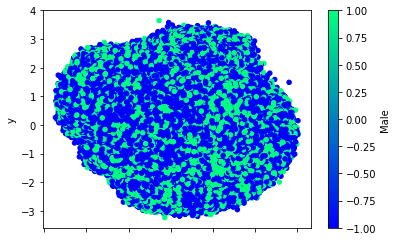

In [183]:
# https://blog.amedama.jp/entry/seaborn-plot
embedding_celebA_pd.plot.scatter(x='x',y='y',c='Male',cmap='winter')

UMAPで次元圧縮するところまで実施。

だが、分離が不十分なのか、明確に分かれるポイントが現時点では不明。

boxplotなどで属性と紐づいているパラメータを明確にする必要がある。

## 以下参考用

In [112]:
# UMAP test by digit
# https://github.com/lmcinnes/umap
import umap
import pandas as pd
from sklearn.datasets import load_digits
import seaborn as sns
from matplotlib import pyplot as plt

digits = load_digits()

embedding = umap.UMAP().fit_transform(digits.data)
embedding_pd = pd.DataFrame(embedding)
embedding_pd.columns = ['x','y']
# https://note.nkmk.me/python-pandas-assign-append/
embedding_pd['target'] = digits.target

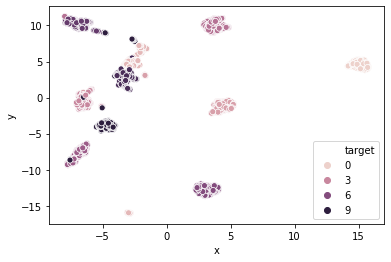

In [113]:
# https://blog.amedama.jp/entry/seaborn-plot
sns.scatterplot(data=embedding_pd, x='x', y='y', hue='target')
plt.show()

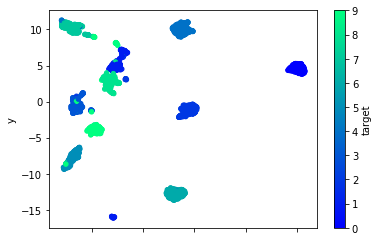

In [184]:
# https://note.nkmk.me/python-pandas-plot/
# http://sinhrks.hatenablog.com/entry/2015/11/15/222543
embedding_pd.plot.scatter(x='x',y='y',c='target',cmap='winter')

In [108]:
print(digits.target)
print(len(digits.target))

print(type(digits.data))
print(digits.data.shape)
print(embedding)
print(embedding.shape)

print(embedding_pd)
print(embedding_pd.columns)

[0 1 2 ... 8 9 8]
1797
<class 'numpy.ndarray'>
(1797, 64)
[[16.23515     3.9268696 ]
 [ 1.3810728  -4.0612698 ]
 [ 2.1960485  -2.3227684 ]
 ...
 [-0.6092358  -2.4799278 ]
 [-4.816149   -2.5296636 ]
 [-0.88474554 -1.9763017 ]]
(1797, 2)
              x          y  target
0     16.235149   3.926870       0
1      1.381073  -4.061270       1
2      2.196048  -2.322768       2
3     -2.235056   0.817878       3
4      5.214112  10.672441       4
...         ...        ...     ...
1792  -5.465918  -2.415040       9
1793  16.745192   3.091624       0
1794  -0.609236  -2.479928       8
1795  -4.816149  -2.529664       9
1796  -0.884746  -1.976302       8

[1797 rows x 3 columns]
Index(['x', 'y', 'target'], dtype='object')


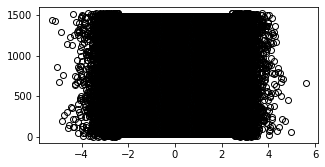

In [81]:
# boxplot
# https://qiita.com/ShoheiKojima/items/e11240de50ddfadecba7
import numpy as np
import matplotlib.pyplot as plt

data=encoded_numpy_T

print(data)

# boxplot
fig=plt.figure(figsize=(5,2.5))
ax=fig.add_subplot(111)
ax.boxplot(data,
           vert=False,  # 横向きにする
           patch_artist=True,  # 細かい設定をできるようにする
           widths=0.5,  # boxの幅の設定
           boxprops=dict(facecolor='#1E90FF80',  # boxの塗りつぶし色の設定
                         color='black', linewidth=1),  # boxの枠線の設定
           medianprops=dict(color='black', linewidth=1),  # 中央値の線の設定
           whiskerprops=dict(color='black', linewidth=1),  # ヒゲの線の設定
           capprops=dict(color='black', linewidth=1),  # ヒゲの先端の線の設定
           flierprops=dict(markeredgecolor='black', markeredgewidth=1)  # 外れ値の設定
           )